In [1]:
!pip install numpy statsmodels matplotlib seaborn pandas

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.diagnostic import kstest_normal
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import binom_test
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import binom_test, proportions_ztest, proportions_chisquare
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
st.norm.rvs(size=10)

array([ 0.27240795,  0.35863443, -0.77226889,  0.15565432,  1.53859184,
        0.80087025, -0.19276966,  0.35925416, -0.41266943, -1.04684332])

In [4]:
st.laplace.rvs(size=10)

array([ 0.29828787,  0.0452698 , -1.36829195,  1.10990596,  1.22496374,
       -0.02874626,  0.16276998,  0.38385315, -0.9406418 , -1.24239711])

In [5]:
st.t.rvs(size=10, df=10)

array([ 1.95421947,  1.33329896,  0.78361137, -1.10023994, -0.14779831,
        2.35094305, -1.72286637,  0.14699083,  1.48378061, -0.17401611])

In [6]:
def rvs_restricted_norm(size=1, loc=0, scale=1, random_state=42):
  sample = st.norm.rvs(size=size*2, random_state=42, loc=loc, scale=scale)
  return sample[np.abs(sample) < 2][:size]

rvs_restricted_norm(size=100)

array([ 0.49671415, -0.1382643 ,  0.64768854,  1.52302986, -0.23415337,
       -0.23413696,  1.57921282,  0.76743473, -0.46947439,  0.54256004,
       -0.46341769, -0.46572975,  0.24196227, -1.91328024, -1.72491783,
       -0.56228753, -1.01283112,  0.31424733, -0.90802408, -1.4123037 ,
        1.46564877, -0.2257763 ,  0.0675282 , -1.42474819, -0.54438272,
        0.11092259, -1.15099358,  0.37569802, -0.60063869, -0.29169375,
       -0.60170661,  1.85227818, -0.01349722, -1.05771093,  0.82254491,
       -1.22084365,  0.2088636 , -1.95967012, -1.32818605,  0.19686124,
        0.73846658,  0.17136828, -0.11564828, -0.3011037 , -1.47852199,
       -0.71984421, -0.46063877,  1.05712223,  0.34361829, -1.76304016,
        0.32408397, -0.38508228, -0.676922  ,  0.61167629,  1.03099952,
        0.93128012, -0.83921752, -0.30921238,  0.33126343,  0.97554513,
       -0.47917424, -0.18565898, -1.10633497, -1.19620662,  0.81252582,
        1.35624003, -0.07201012,  1.0035329 ,  0.36163603, -0.64

In [57]:
from functools import partial
from dataclasses import dataclass

@dataclass
class Result:
  pvalue: float
  statistic: float

def kstest_normal_(*args, **kwargs):
    result = kstest_normal(*args, **kwargs)
    return  Result(pvalue=result[1], statistic=result[0])

samplers = [
    (st.norm.rvs),
    (st.laplace.rvs),
    partial(st.t.rvs, df=10),
    (rvs_restricted_norm),
]
samplers_parameters = [
    [{"scale": scale} for scale in np.linspace(0.1, 10, num=50)],
    [{"scale": scale} for scale in np.linspace(0.1, 10, num=50)],
    [{"df": df} for df in range(1, 50, 2)],
    [{"scale": scale} for scale in np.linspace(0.1, 2, num=10)],
]
samplers_names = [
    "normal",
    "laplace",
    "t",
    "restricted normal"
]
criterias = [
    partial(kstest_normal_, dist='norm', pvalmethod='approx'),
    st.shapiro,
    st.jarque_bera
]
criterias_names = [
    "Lilliefors",
    "Shapiro",
    "Jarque-Bera"
]

In [15]:
criterias[2]([1,1,0,00,0])

SignificanceResult(statistic=0.8391203703703703, pvalue=0.657335862298362)

In [31]:
samplers[0](size=10, **samplers_parameters[0][0], random_state=42)

array([ 0.04967142, -0.01382643,  0.06476885,  0.15230299, -0.02341534,
       -0.0234137 ,  0.15792128,  0.07674347, -0.04694744,  0.054256  ])

In [60]:
from collections import defaultdict
N_exp = 100
# alpha = 0.05

results = {}

for sampler_name, sampler_parameters, sampler in zip(
    samplers_names,
    samplers_parameters,
    samplers
):
    criteria_to_n_rejections = defaultdict(list)
    for sampler_parameters_i in sampler_parameters:
      for criteria_name in criterias_names:
        criteria_to_n_rejections[criteria_name].append(0)
      for i in range(N_exp):
          sample = sampler(size=20, random_state=i, **sampler_parameters_i)
          for criteria_name, criteria in zip(criterias_names, criterias):
              # criteria_to_n_rejections[criteria_name][-1] += int(criteria(sample).pvalue < alpha) / N_exp
              criteria_to_n_rejections[criteria_name][-1] += criteria(sample).pvalue / N_exp
    results[sampler_name] = criteria_to_n_rejections


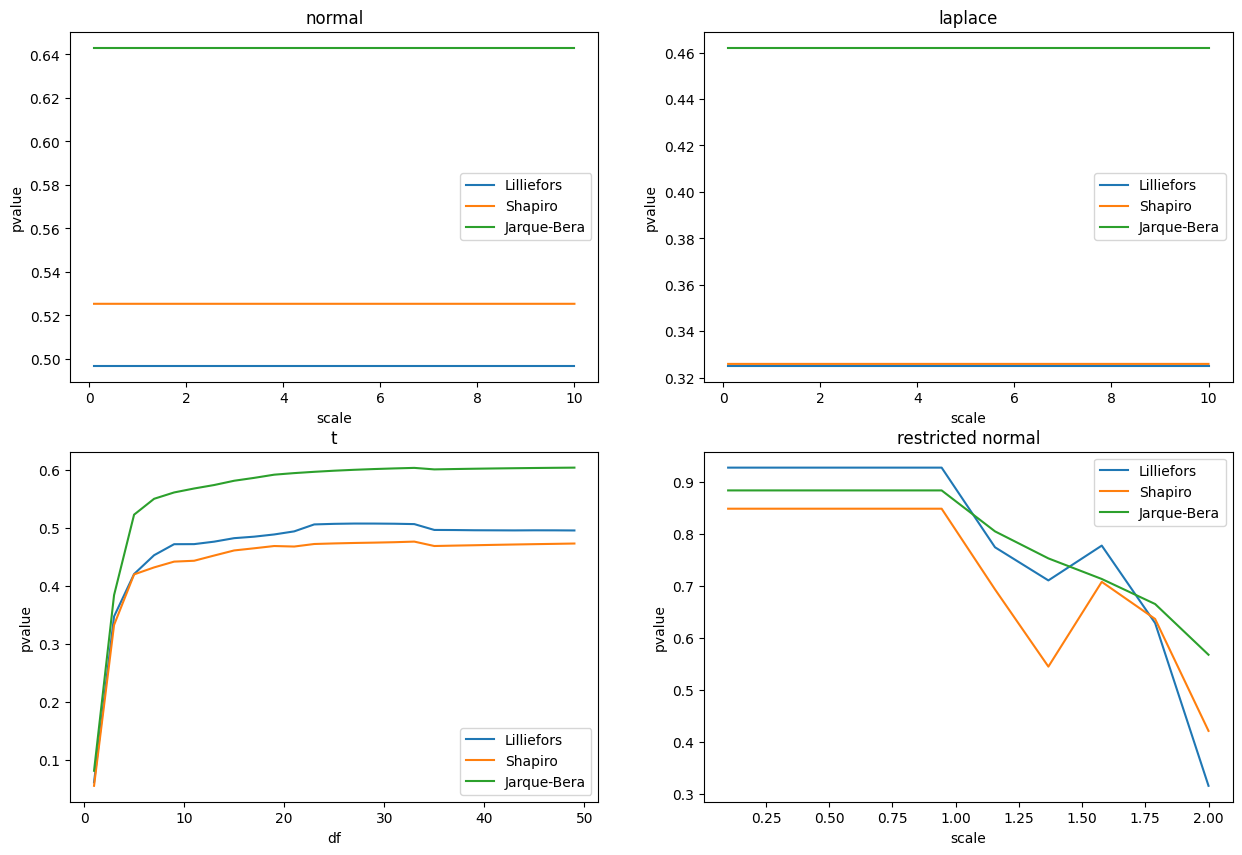

In [61]:
f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for ax, sampler_name, sampler_parameters in zip(
    axs,
    samplers_names,
    samplers_parameters,
):
  sampler_parameter = list(sampler_parameters[0].keys())[0]
  sampler_parameter_values = [parameters[sampler_parameter] for parameters in sampler_parameters]
  for criteria_name in criterias_names:
    ax.plot(sampler_parameter_values, results[sampler_name][criteria_name])
  ax.set_xlabel(sampler_parameter)
  ax.set_ylabel("pvalue")
  ax.set_title(sampler_name)
  ax.legend(criterias_names)

Шапиро -- боле мощный кретирий (в рассмотренных альтернативах).


In [46]:
# criterias are not affected by the change in scale
normal_sampler = samplers[0]
shapiro_criteria = criterias[1]
sample = normal_sampler(size=20, random_state=2, scale=10)
sample2 = normal_sampler(size=20, random_state=2, scale=1)
shapiro_criteria(sample), shapiro_criteria(sample2)

(ShapiroResult(statistic=0.9746570587158203, pvalue=0.848469078540802),
 ShapiroResult(statistic=0.974656879901886, pvalue=0.848465085029602))

# Зависимость от n

In [62]:
from collections import defaultdict
N_exp = 1000
alpha = 0.05

results = {}

for sampler_name, sampler in zip(
    samplers_names,
    samplers
):
    criteria_to_n_rejections = defaultdict(list)
    for n in range(5, 100, 5):
      for criteria_name in criterias_names:
        criteria_to_n_rejections[criteria_name].append(0)
      for i in range(N_exp):
          sample = sampler(size=n, random_state=i)
          for criteria_name, criteria in zip(criterias_names, criterias):
              # criteria_to_n_rejections[criteria_name][-1] += int(criteria(sample).pvalue < alpha) / N_exp
              criteria_to_n_rejections[criteria_name][-1] += criteria(sample).pvalue / N_exp
    results[sampler_name] = criteria_to_n_rejections


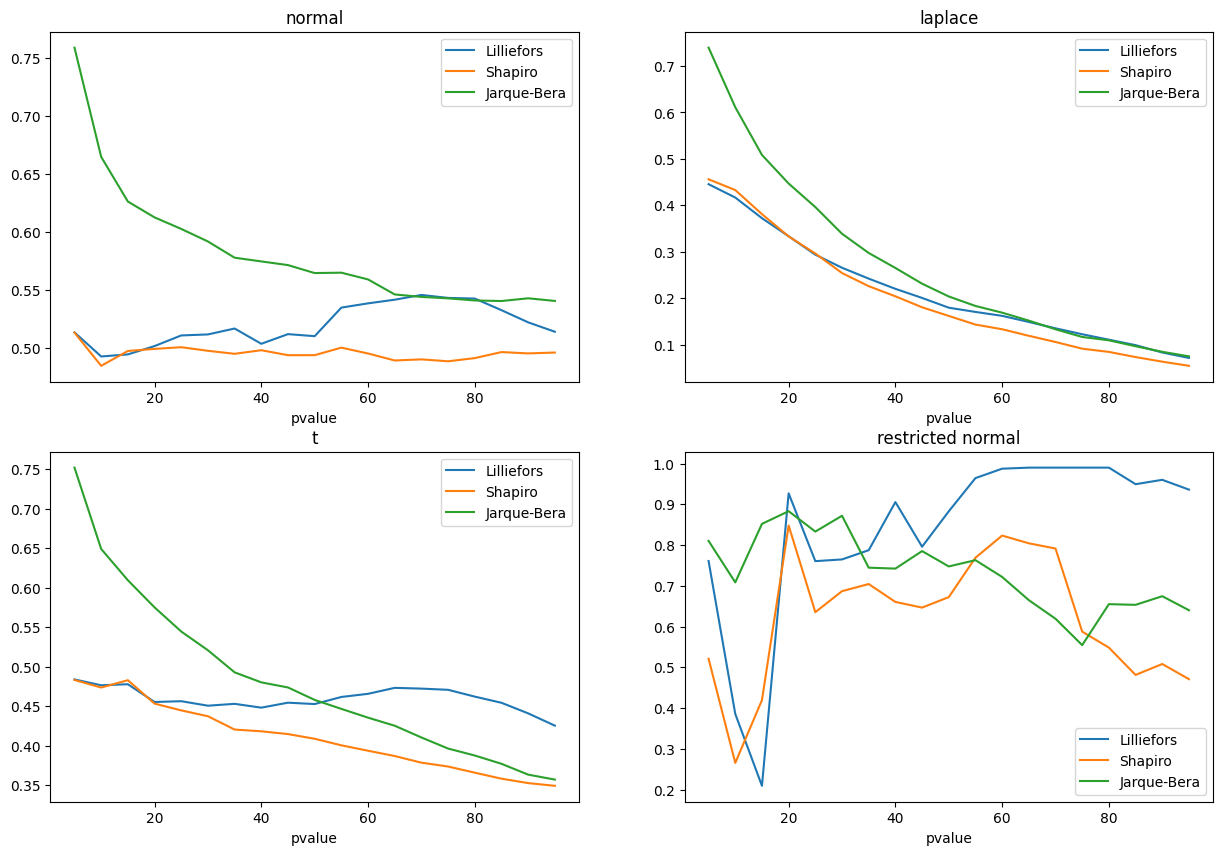

In [65]:
f, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()

for ax, sampler_name, in zip(
    axs,
    samplers_names,
):
  ns = range(5, 100, 5)
  for criteria_name in criterias_names:
    ax.plot(ns, results[sampler_name][criteria_name])
  ax.set_xlabel("n")
  ax.set_xlabel("pvalue")
  ax.set_title(sampler_name)
  ax.legend(criterias_names)